In [1]:
import os
import argparse
import torch
from networks.vnet import VNet
#from test_util import  predict_and_center_cut_all_case

# parser = argparse.ArgumentParser()
# parser.add_argument('--root_path', type=str, default='../data/CTM_dataset/unSegmented', help='Folder of Test Set')
# parser.add_argument('--model', type=str,  default='vnet_supervisedonly_dp', help='model_name')
# parser.add_argument('--gpu', type=str,  default='0', help='GPU to use')
# FLAGS = parser.parse_args()
# os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
# snapshot_path = "../model/"+FLAGS.model+"/"
# test_save_path = "../model/prediction/"+FLAGS.model+"_post/"


root_path='../../data/gz_dataset/unsegmented/success'
model='vnet_supervisedonly_dp'
gpu='0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu
snapshot_path = "../model/"+model+"/"
# test_save_path = "../model/prediction/unSegmented/"+model+"_post/"
test_save_path = "../model/prediction/unSegmented_center_cut/"+model+"_post/"
if not os.path.exists(test_save_path):
    os.makedirs(test_save_path)

num_classes = 4

with open(root_path + '/../../train_unseg.list', 'r') as f:
    image_list = f.readlines()
image_list = [os.path.join(root_path,item.replace('\n', ''),"mri_norm2.h5") for item in image_list]

def center_cut_all_case(
    epoch_num, 
    patch_size=(128, 128, 64), 
    stride_xy=64, 
    stride_z=32,
    device='cuda'
):
    print("begin")
    net = VNet(n_channels=1, n_classes=num_classes, normalization='batchnorm', has_dropout=False).to(device)
    print("afternet")
    save_mode_path = os.path.join(snapshot_path, 'iter_' + str(epoch_num) + '.pth')
    net.load_state_dict(torch.load(save_mode_path))
    print("load")
    print("init weight from {}".format(save_mode_path))
    net.eval()
    print("after eval")

    predict_and_center_cut_all_case(
        net, image_list, num_classes=num_classes,
        patch_size=patch_size, stride_xy=stride_xy, stride_z=stride_z,
        save_result=True, test_save_path=test_save_path,
        device=device)
    print("finish")



In [20]:
# -*- coding: utf-8 -*-
# +
import h5py
import math
import nibabel as nib
import numpy as np
from medpy import metric
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os


def predict_and_center_cut_all_case(net, image_list, num_classes, 
                        patch_size=(112, 112, 80), stride_xy=18, stride_z=4, 
                        save_result=True, test_save_path=None, preproc_fn=None,
                        device='cpu'):
    for image_path in tqdm(image_list):
        id = image_path.split('/')[-2]
        print(id,':')
        out_dir = test_save_path+id
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
            
        h5f = h5py.File(image_path, 'r')
        image = h5f['image'][:]
        if preproc_fn is not None:
            image = preproc_fn(image)
        label_pred, score_map = test_single_case(
            net, image, 
            stride_xy, stride_z, patch_size, 
            num_classes=num_classes, 
            device=device)
        
        #import pdb
        #pdb.set_trace()
        filter_mask = filter_connected_domain(label_pred,num_keep_region=None,ratio_keep=0.1)
        filter_mask = (filter_mask>0).astype(float)
        #import pdb
        #pdb.set_trace()
        label_pred = label_pred*filter_mask

        # 发现圆形视场的边界处经常出现错误分割(轮廓线),因此需要手动过滤
        r = label_pred.shape[0]/2
        xc,yc = label_pred.shape[0]/2,label_pred.shape[0]/2
#         filter_mask = np.ones(label_pred.shape)
#         for x in range(label_pred.shape[0]):
#             for y in range(label_pred.shape[1]):
#                 filter_mask[x,y,:] = 0 if r*0.5<np.sqrt((x-xc)**2+(y-yc)**2)<r*2 else 1
#         label_pred = filter_mask*label_pred
        
        #import pdb
        #pdb.set_trace()
        # onehot
        label_onehot_pred = tf.keras.utils.to_categorical(label_pred)
        print("shape: ",label_onehot_pred.shape)
        '''if not label_onehot_pred.shape[-1]==4:
            print(id+' onehot shape error: miss one or more pixel class')
            continue'''
            
        # center cut
        tempL = np.nonzero(label_pred)
        minx, maxx = np.min(tempL[0]).astype(int), np.max(tempL[0]).astype(int)
        miny, maxy = np.min(tempL[1]).astype(int), np.max(tempL[1]).astype(int)
        minz, maxz = np.min(tempL[2]).astype(int), np.max(tempL[2]).astype(int)
        print(minx,maxx,miny, maxy,minz, maxz)
        if ((maxy+1-80)>miny):
            image = image[minx:maxx+1, miny:maxy+1-80, minz:maxz+1]
            label_pred = label_pred[minx:maxx+1, miny:maxy+1-80, minz:maxz+1]
            label_onehot_pred = label_onehot_pred[minx:maxx+1, miny:maxy+1-80, minz:maxz+1, :]
        else:
            image = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
            label_pred = label_pred[minx:maxx+1, miny:maxy+1, minz:maxz+1]
            label_onehot_pred = label_onehot_pred[minx:maxx+1, miny:maxy+1, minz:maxz+1, :]
            
        # case 拼接
        numd = []
        for d in range(label_pred.shape[0]):
            numd.append( len(np.where(label_pred[d,:,:].flatten()==2)[0]) )
        numd = np.array(numd)
        slice = int(np.where(numd==numd.max())[0][0])
        fig = plt.figure( frameon=False)#dpi=100, 
        image_unstd = (image-image.min())/(image.max()-image.min())*255
        npimg = np.append( image_unstd[slice,:,:],label_pred[slice,:,:]/2*255,axis=1 )
        plt.imshow(npimg.astype(int),cmap='plasma')#一定要转为int
        plt.savefig( test_save_path + id + str(slice) + "_pred.png" )
        plt.show()
        
        #import pdb
        #pdb.set_trace()
        
        if save_result:
            # save files
            filename = os.path.join(os.path.dirname(image_path),'center_cut.h5')
            print('filename: ',filename)
            f = h5py.File(filename, 'w')
            f.create_dataset('image', data=image.astype(np.float32), compression="gzip")
            print("final_shape: ",image.shape)
#             f.create_dataset('label', data=label_onehot_pred.astype(np.int), compression="gzip")
            f.close()
#             nib.save(nib.Nifti1Image(image[:].astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_img.nii.gz")
#             nib.save(nib.Nifti1Image(label_pred.astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_pred.nii.gz")
#             nib.save(nib.Nifti1Image(label_onehot_pred[:].astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_label_onehot_pred.nii.gz")
    print('All finished')


# -

from skimage import measure
def filter_connected_domain(image,num_keep_region=100,ratio_keep=None):
    """
    原文链接：https://blog.csdn.net/a563562675/article/details/107066836
    return label of filter 
    """
    # 标记输入的3D图像
    label, num = measure.label(image, connectivity=1, background=0, return_num=True)
    if num < 1:
        return image

    # 获取对应的region对象
    region = measure.regionprops(label)
    # 获取每一块区域面积并排序
    num_list = [i for i in range(0, num)]
    area_list = [region[i].area for i in num_list]
    
    # 去除面积较小的连通域
    if ratio_keep:
        max_region_area = np.array(area_list).max()
        #import pdb
        #pdb.set_trace()
        drop_list = np.where(area_list<max_region_area*ratio_keep)[0]
        for i in drop_list:
            label[region[i].slice][region[i].image] = 0 
    
    else:
        if len(num_list) > num_keep_region:
            num_list_sorted = sorted(num_list, key=lambda x: area_list[x])[::-1]# 面积由大到小排序
            for i in num_list_sorted[num_keep_region:]:
                # label[label==i] = 0
                label[region[i].slice][region[i].image] = 0
#             num_list_sorted = num_list_sorted[:num_keep_region]
    #import pdb
    #pdb.set_trace()
    return label


def test_all_case(
    net, image_list, 
    num_classes, 
    name_classes,
    patch_size=(112, 112, 80), stride_xy=18, stride_z=4, 
    save_result=True, test_save_path=None, preproc_fn=None,
    device="cuda"
):
    if num_classes==2:
        cols = ['dice','jc','hd','asd']
    else:
        cols = [['dice']*len(name_classes)+['jc']*len(name_classes)+['hd']*len(name_classes)+['asd']*len(name_classes), name_classes*4]
    metrics = pd.DataFrame(columns=cols) 

    for image_path in tqdm(image_list):
        id = image_path.split('/')[-2]
        h5f = h5py.File(image_path, 'r')
        image = h5f['image'][:]
        label = np.argmax(h5f['label'][:],axis=-1)
        if preproc_fn is not None:
            image = preproc_fn(image)
        prediction, score_map = test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=num_classes, device="cuda")

        if np.sum(prediction)==0:
            single_metric = (0,0,0,0)
        else:
            single_metric = calculate_metric_percase(prediction, label[:], num_classes)
        
        print(id,':')
        print("single_metric:",single_metric)

        metrics.loc[id] = np.array(single_metric).flatten().tolist()
        if save_result:
            nib.save(nib.Nifti1Image(prediction.astype(np.float32), np.eye(4)), test_save_path + id + "_pred.nii.gz")
            nib.save(nib.Nifti1Image(image[:].astype(np.float32), np.eye(4)), test_save_path + id + "_img.nii.gz")
            nib.save(nib.Nifti1Image(label[:].astype(np.float32), np.eye(4)), test_save_path + id + "_gt.nii.gz")
    mean_metrics = metrics.mean()
    print('mean metric is:\n')
    print(mean_metrics)

    return metrics


def test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=1, device="cuda"):
    w, h, d = image.shape

    # if the size of image is less than patch_size, then padding it
    add_pad = False
    if w < patch_size[0]:
        w_pad = patch_size[0]-w
        add_pad = True
    else:
        w_pad = 0
    if h < patch_size[1]:
        h_pad = patch_size[1]-h
        add_pad = True
    else:
        h_pad = 0
    if d < patch_size[2]:
        d_pad = patch_size[2]-d
        add_pad = True
    else:
        d_pad = 0
    wl_pad, wr_pad = w_pad//2,w_pad-w_pad//2
    hl_pad, hr_pad = h_pad//2,h_pad-h_pad//2
    dl_pad, dr_pad = d_pad//2,d_pad-d_pad//2
    if add_pad:
        image = np.pad(image, [(wl_pad,wr_pad),(hl_pad,hr_pad), (dl_pad, dr_pad)], mode='constant', constant_values=0)
    ww,hh,dd = image.shape

    sx = math.ceil((ww - patch_size[0]) / stride_xy) + 1
    sy = math.ceil((hh - patch_size[1]) / stride_xy) + 1
    sz = math.ceil((dd - patch_size[2]) / stride_z) + 1
    print("{}, {}, {}".format(sx, sy, sz))
    score_map = np.zeros((num_classes, ) + image.shape).astype(np.float32)
    cnt = np.zeros(image.shape).astype(np.float32)

    for x in range(0, sx):
        xs = min(stride_xy*x, ww-patch_size[0])
        for y in range(0, sy):
            ys = min(stride_xy * y,hh-patch_size[1])
            for z in range(0, sz):
                zs = min(stride_z * z, dd-patch_size[2])
                test_patch = image[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]]
                test_patch = np.expand_dims(np.expand_dims(test_patch,axis=0),axis=0).astype(np.float32)
                #test_patch = torch.from_numpy(test_patch).cuda()# gpu
                test_patch = torch.from_numpy(test_patch).to(device)# cpu
                y1 = net(test_patch)
                y = F.softmax(y1, dim=1)
                y = y.cpu().data.numpy()
                y = y[0,:,:,:,:]
                score_map[:, xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += y
                cnt[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += 1
    score_map = score_map/np.expand_dims(cnt,axis=0)
    label_map = np.argmax(score_map, axis = 0)
    if add_pad:
        label_map = label_map[wl_pad:wl_pad+w,hl_pad:hl_pad+h,dl_pad:dl_pad+d]
        score_map = score_map[:,wl_pad:wl_pad+w,hl_pad:hl_pad+h,dl_pad:dl_pad+d]
    return label_map, score_map

def cal_dice(prediction, label, num=2):
    total_dice = np.zeros(num-1)
    for i in range(1, num):
        prediction_tmp = (prediction==i)
        label_tmp = (label==i)
        prediction_tmp = prediction_tmp.astype(np.float)
        label_tmp = label_tmp.astype(np.float)

        dice = 2 * np.sum(prediction_tmp * label_tmp) / (np.sum(prediction_tmp) + np.sum(label_tmp))
        total_dice[i - 1] += dice

    return total_dice

def calculate_metric_percase(pred, gt, num_classes):
    "二分类、多分类的指标统计"
    if num_classes is None:
        num_classes = len(np.unique(gt))#注意：gt不是onehot编码
    print('np.unique(gt):',np.unique(gt))
    if num_classes==2:
        dice = metric.binary.dc(pred, gt)
        jc = metric.binary.jc(pred, gt)
        hd = metric.binary.hd95(pred, gt)
        asd = metric.binary.asd(pred, gt)
    elif num_classes>2:
        from keras.utils import to_categorical
        gt_onehot = to_categorical(gt, num_classes)
        pred_onehot = to_categorical(pred, num_classes)
        dice = []
        jc = []
        hd = []
        asd = []
        for k in range(num_classes):
            pred_k = pred_onehot[...,k]
            gt_k = gt_onehot[...,k]
            dice +=  [metric.dc(result=pred_k, reference=gt_kk)]
            jc += [metric.jc(result=pred_k, reference=gt_k)]
            hd += [metric.hd95(result=pred_k, reference=gt_k)]
            asd += [metric.asd(result=pred_k, reference=gt_k)]
    else:
        raise ValueError("pred和gt不能是onehot编码")
    return dice, jc, hd, asd












  0%|          | 0/42 [00:00<?, ?it/s]

begin
afternet
load
init weight from ../model/vnet_supervisedonly_dp/iter_6001.pth
after eval
032601 :
6, 6, 8
shape:  (400, 400, 271, 4)
63 372 157 366 0 270


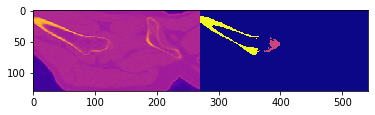

filename:  ../../data/gz_dataset/unsegmented/success/032601/center_cut.h5










  2%|▏         | 1/42 [00:31<21:45, 31.85s/it]

final_shape:  (310, 130, 271)
074856 :
6, 6, 6
shape:  (400, 400, 207, 3)
59 359 135 318 0 206


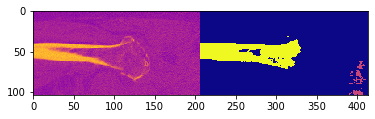

filename:  ../../data/gz_dataset/unsegmented/success/074856/center_cut.h5










  5%|▍         | 2/42 [00:56<19:45, 29.64s/it]

final_shape:  (301, 104, 207)
080640 :
6, 6, 7
shape:  (430, 430, 249, 4)
72 361 196 420 0 248


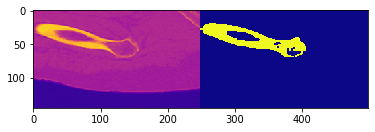

filename:  ../../data/gz_dataset/unsegmented/success/080640/center_cut.h5










  7%|▋         | 3/42 [01:24<19:00, 29.23s/it]

final_shape:  (290, 145, 249)
080940 :
7, 7, 14
shape:  (464, 464, 472, 3)
129 431 192 400 0 471


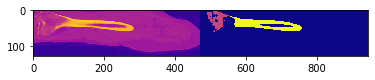

filename:  ../../data/gz_dataset/unsegmented/success/080940/center_cut.h5










 10%|▉         | 4/42 [02:37<26:47, 42.29s/it]

final_shape:  (303, 129, 472)
080940-2 :
7, 7, 14
shape:  (464, 464, 471, 4)
224 462 131 433 0 470


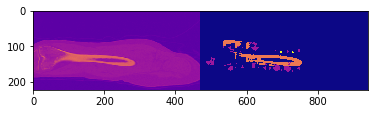

filename:  ../../data/gz_dataset/unsegmented/success/080940-2/center_cut.h5










 12%|█▏        | 5/42 [03:49<31:37, 51.30s/it]

final_shape:  (239, 223, 471)
085514 :
6, 6, 7
shape:  (410, 410, 242, 4)
71 356 197 368 0 241


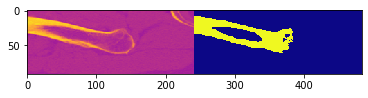

filename:  ../../data/gz_dataset/unsegmented/success/085514/center_cut.h5










 14%|█▍        | 6/42 [04:16<26:25, 44.03s/it]

final_shape:  (286, 92, 242)
090423-metal :
6, 6, 10
shape:  (414, 414, 325, 4)
61 377 155 296 0 324


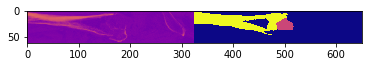

filename:  ../../data/gz_dataset/unsegmented/success/090423-metal/center_cut.h5










 17%|█▋        | 7/42 [04:55<24:44, 42.41s/it]

final_shape:  (317, 62, 325)
100725 :
7, 7, 9
shape:  (482, 482, 291, 4)
65 434 193 418 0 290


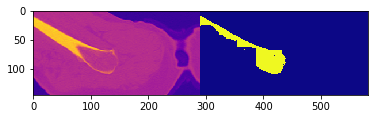

filename:  ../../data/gz_dataset/unsegmented/success/100725/center_cut.h5










 19%|█▉        | 8/42 [05:43<25:01, 44.16s/it]

final_shape:  (370, 146, 291)
101925 :
7, 7, 7
shape:  (464, 464, 234, 4)
25 397 149 417 0 233


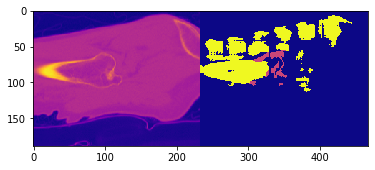

filename:  ../../data/gz_dataset/unsegmented/success/101925/center_cut.h5










 21%|██▏       | 9/42 [06:22<23:20, 42.45s/it]

final_shape:  (373, 189, 234)
102424 :
7, 7, 15
shape:  (473, 473, 509, 4)
12 331 141 409 0 508


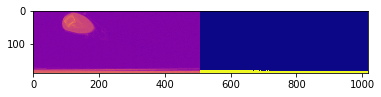

filename:  ../../data/gz_dataset/unsegmented/success/102424/center_cut.h5










 24%|██▍       | 10/42 [07:42<28:39, 53.74s/it]

final_shape:  (320, 189, 509)
111016 :
5, 5, 5
shape:  (380, 380, 189, 4)
29 341 182 296 0 142


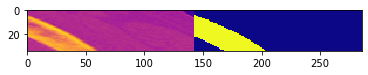

filename:  ../../data/gz_dataset/unsegmented/success/111016/center_cut.h5
final_shape:  (313, 35, 143)










 26%|██▌       | 11/42 [07:56<21:40, 41.96s/it]

112241 :
6, 6, 13
shape:  (400, 400, 429, 4)
99 330 169 388 0 428


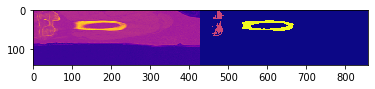

filename:  ../../data/gz_dataset/unsegmented/success/112241/center_cut.h5










 29%|██▊       | 12/42 [08:46<22:06, 44.23s/it]

final_shape:  (232, 140, 429)
112241-2 :
6, 6, 9
shape:  (400, 400, 297, 3)
25 345 191 244 0 296


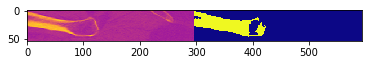

filename:  ../../data/gz_dataset/unsegmented/success/112241-2/center_cut.h5










 31%|███       | 13/42 [09:20<19:53, 41.17s/it]

final_shape:  (321, 54, 297)
113353 :
7, 7, 6
shape:  (449, 449, 221, 4)
49 387 178 399 0 220


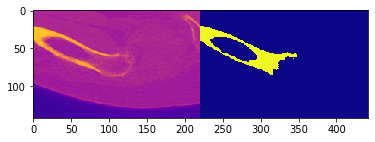

filename:  ../../data/gz_dataset/unsegmented/success/113353/center_cut.h5










 33%|███▎      | 14/42 [09:52<17:54, 38.39s/it]

final_shape:  (339, 142, 221)
120446 :
6, 6, 7
shape:  (400, 400, 255, 4)
75 343 192 366 0 254


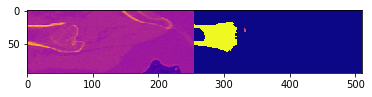

filename:  ../../data/gz_dataset/unsegmented/success/120446/center_cut.h5










 36%|███▌      | 15/42 [10:19<15:48, 35.14s/it]

final_shape:  (269, 95, 255)
120728 :
3, 3, 7
shape:  (241, 241, 253, 3)
75 169 126 180 0 168


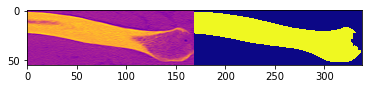









 38%|███▊      | 16/42 [10:27<11:40, 26.94s/it]

filename:  ../../data/gz_dataset/unsegmented/success/120728/center_cut.h5
final_shape:  (95, 55, 169)
123209 :
7, 7, 10
shape:  (496, 496, 322, 4)
35 490 48 443 0 321


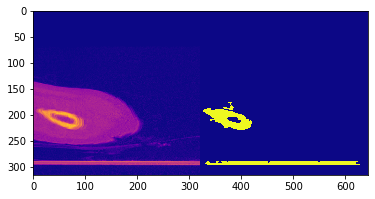

filename:  ../../data/gz_dataset/unsegmented/success/123209/center_cut.h5










 40%|████      | 17/42 [11:25<15:10, 36.42s/it]

final_shape:  (456, 316, 322)
125020 :
5, 5, 7
shape:  (334, 334, 241, 4)
10 274 160 260 0 239


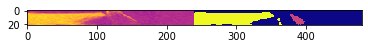









 43%|████▎     | 18/42 [11:44<12:27, 31.13s/it]

filename:  ../../data/gz_dataset/unsegmented/success/125020/center_cut.h5
final_shape:  (265, 21, 240)
130213 :
5, 5, 6
shape:  (382, 382, 219, 3)
52 342 201 265 0 170


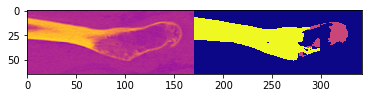

filename:  ../../data/gz_dataset/unsegmented/success/130213/center_cut.h5










 45%|████▌     | 19/42 [12:02<10:20, 26.98s/it]

final_shape:  (291, 65, 171)
133612 :
6, 6, 6
shape:  (400, 400, 217, 4)
42 344 148 361 0 216


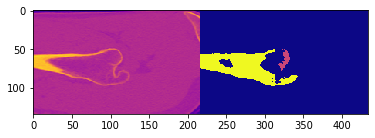

filename:  ../../data/gz_dataset/unsegmented/success/133612/center_cut.h5










 48%|████▊     | 20/42 [12:26<09:35, 26.15s/it]

final_shape:  (303, 134, 217)
134713 :
6, 6, 6
shape:  (423, 423, 209, 4)
25 382 176 360 0 208


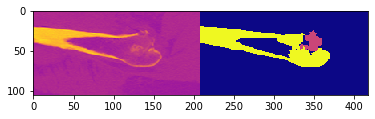

filename:  ../../data/gz_dataset/unsegmented/success/134713/center_cut.h5










 50%|█████     | 21/42 [12:50<08:58, 25.65s/it]

final_shape:  (358, 105, 209)
135234 :
6, 6, 20
shape:  (433, 433, 651, 4)
13 430 73 404 0 650


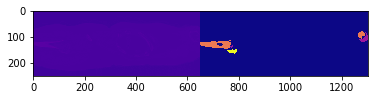

filename:  ../../data/gz_dataset/unsegmented/success/135234/center_cut.h5










 52%|█████▏    | 22/42 [14:15<14:28, 43.42s/it]

final_shape:  (418, 252, 651)
144442 :
6, 6, 8
shape:  (425, 425, 275, 3)
46 378 142 274 0 266


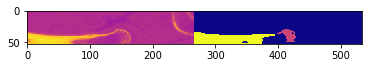

filename:  ../../data/gz_dataset/unsegmented/success/144442/center_cut.h5










 55%|█████▍    | 23/42 [14:46<12:35, 39.76s/it]

final_shape:  (333, 53, 267)
145101 :
3, 3, 14
shape:  (254, 254, 463, 4)
50 208 74 229 0 462


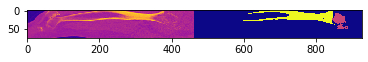

filename:  ../../data/gz_dataset/unsegmented/success/145101/center_cut.h5










 57%|█████▋    | 24/42 [15:02<09:44, 32.47s/it]

final_shape:  (159, 76, 463)
145101-2 :
6, 6, 8
shape:  (445, 445, 263, 4)
47 411 98 362 0 262


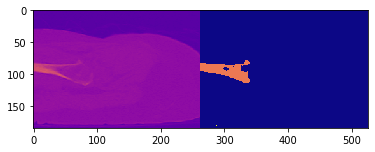

filename:  ../../data/gz_dataset/unsegmented/success/145101-2/center_cut.h5










 60%|█████▉    | 25/42 [15:35<09:14, 32.62s/it]

final_shape:  (365, 185, 263)
151000 :
3, 3, 13
shape:  (232, 232, 438, 4)
38 173 127 204 0 417


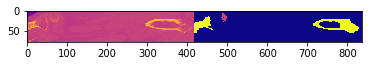

filename:  ../../data/gz_dataset/unsegmented/success/151000/center_cut.h5










 62%|██████▏   | 26/42 [15:49<07:13, 27.08s/it]

final_shape:  (136, 78, 418)
152257 :
6, 6, 7
shape:  (400, 400, 250, 4)
7 376 178 371 0 249


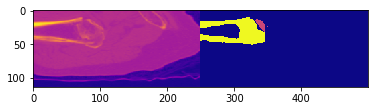

filename:  ../../data/gz_dataset/unsegmented/success/152257/center_cut.h5










 64%|██████▍   | 27/42 [16:17<06:51, 27.41s/it]

final_shape:  (370, 114, 250)
154239 :
6, 6, 9
shape:  (387, 387, 303, 3)
72 353 166 232 0 280


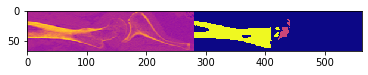

filename:  ../../data/gz_dataset/unsegmented/success/154239/center_cut.h5










 67%|██████▋   | 28/42 [16:52<06:53, 29.55s/it]

final_shape:  (282, 67, 281)
165826 :
6, 6, 9
shape:  (391, 391, 301, 3)
47 347 144 243 0 223


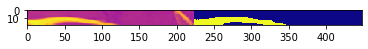









 69%|██████▉   | 29/42 [17:25<06:38, 30.65s/it]

filename:  ../../data/gz_dataset/unsegmented/success/165826/center_cut.h5
final_shape:  (301, 20, 224)
170920 :
3, 3, 8
shape:  (225, 225, 277, 3)
58 145 27 116 0 207


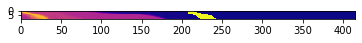









 71%|███████▏  | 30/42 [17:33<04:48, 24.00s/it]

filename:  ../../data/gz_dataset/unsegmented/success/170920/center_cut.h5
final_shape:  (88, 10, 208)
171247 :
6, 6, 5
shape:  (418, 418, 183, 3)
54 359 200 273 0 158


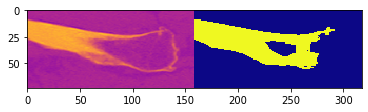

filename:  ../../data/gz_dataset/unsegmented/success/171247/center_cut.h5










 74%|███████▍  | 31/42 [17:53<04:10, 22.75s/it]

final_shape:  (306, 74, 159)
174219 :
6, 6, 8
shape:  (400, 400, 275, 3)
42 340 192 252 0 258


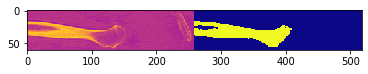

filename:  ../../data/gz_dataset/unsegmented/success/174219/center_cut.h5










 76%|███████▌  | 32/42 [18:24<04:11, 25.20s/it]

final_shape:  (299, 61, 259)
180200 :
6, 6, 6
shape:  (447, 447, 205, 4)
63 371 188 428 0 204


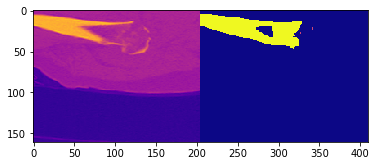

filename:  ../../data/gz_dataset/unsegmented/success/180200/center_cut.h5










 79%|███████▊  | 33/42 [18:49<03:46, 25.13s/it]

final_shape:  (309, 161, 205)
182503 :
6, 6, 7
shape:  (402, 402, 251, 4)
41 342 177 369 0 250


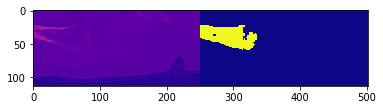

filename:  ../../data/gz_dataset/unsegmented/success/182503/center_cut.h5










 81%|████████  | 34/42 [19:17<03:27, 25.94s/it]

final_shape:  (302, 113, 251)
184647 :
4, 4, 8
shape:  (264, 264, 279, 3)
52 258 116 196 0 278


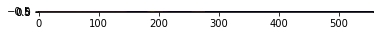









 83%|████████▎ | 35/42 [19:31<02:36, 22.29s/it]

filename:  ../../data/gz_dataset/unsegmented/success/184647/center_cut.h5
final_shape:  (207, 1, 279)
190409 :
3, 3, 15
shape:  (201, 201, 491, 3)
42 150 62 140 64 471


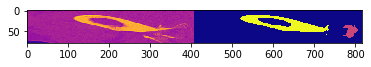

filename:  ../../data/gz_dataset/unsegmented/success/190409/center_cut.h5










 86%|████████▌ | 36/42 [19:46<02:00, 20.07s/it]

final_shape:  (109, 79, 408)
200617 :
4, 4, 14
shape:  (264, 264, 479, 3)
73 175 126 195 0 455


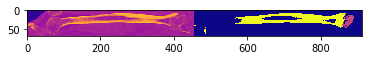

filename:  ../../data/gz_dataset/unsegmented/success/200617/center_cut.h5










 88%|████████▊ | 37/42 [20:09<01:45, 21.18s/it]

final_shape:  (103, 70, 456)
201154 :
6, 6, 18
shape:  (400, 400, 597, 4)
58 359 129 377 0 596


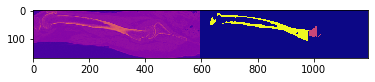

filename:  ../../data/gz_dataset/unsegmented/success/201154/center_cut.h5










 90%|█████████ | 38/42 [21:20<02:23, 35.96s/it]

final_shape:  (302, 169, 597)
205211 :
5, 5, 5
shape:  (379, 379, 183, 4)
53 330 184 245 0 127


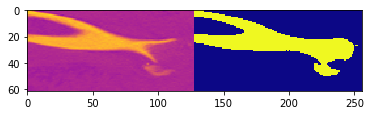

filename:  ../../data/gz_dataset/unsegmented/success/205211/center_cut.h5










 93%|█████████▎| 39/42 [21:34<01:28, 29.50s/it]

final_shape:  (278, 62, 128)
221205 :
6, 6, 7
shape:  (412, 412, 235, 4)
58 358 144 255 0 233


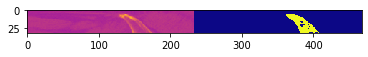

filename:  ../../data/gz_dataset/unsegmented/success/221205/center_cut.h5










 95%|█████████▌| 40/42 [22:01<00:57, 28.76s/it]

final_shape:  (301, 32, 234)
223849 :
4, 4, 7
shape:  (279, 279, 241, 4)
11 241 133 229 0 231


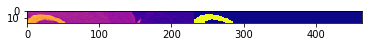









 98%|█████████▊| 41/42 [22:14<00:23, 23.87s/it]

filename:  ../../data/gz_dataset/unsegmented/success/223849/center_cut.h5
final_shape:  (231, 17, 232)
233937 :
4, 4, 6
shape:  (316, 316, 214, 3)
104 175 136 186 0 159


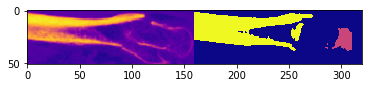









100%|██████████| 42/42 [22:25<00:00, 32.03s/it]

filename:  ../../data/gz_dataset/unsegmented/success/233937/center_cut.h5
final_shape:  (72, 51, 160)
All finished
finish


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
center_cut_all_case(6001, patch_size=(128, 128, 64), stride_xy=64, stride_z=32, device=device)

In [2]:
import os
import argparse
import torch
from networks.vnet import VNet
from test_util import  predict_and_center_cut_all_case
torch.cuda.is_available()

True

In [ ]:
'minX%d_maxX%d_minY%d_maxY%d_minZ%d_maxZ%d'%(2,3,4,5,6,7)

In [ ]:
214*25/3600

In [ ]:
500*500*70